# 1. Alkaline Electrolyzer Model (Sanchez et al.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import cm  # color map
from scipy.optimize import fsolve
%matplotlib inline

In [2]:
# Colors for plotting
black = 'black'
red = '#d3494e'
green = '#087804'
blue = '#0343df'

## 1.1 Parameters

In [3]:
F = 96485.3321 # Faraday constant [sA/mol]
M_h2 = 2.0159e-3 # kg/mol

## 1.2 Electrolyzer settings

In [4]:
# Operating parameters
T_op = 90 #Operating temperature [C]
Pr=30 # Operating pressure [bar]
P_min = 0.15 # Minimum operating power [%]
i_max = 5000 # Maximum current density [A/m2]

# Size
El_cap = 20.0 # Electrolyzer capcity [MW]

## 1.3 Open circuit voltage

In [5]:
# Open circuit voltage as a function of temperature (at standard pressure) 
def U_rev(T):
    U_rev = 1.5184-1.5421*1e-3*(T+273.15)+9.523*1e-5*(T+273.15)*np.log(T+273.15)+9.84*1e-8*(T+273.15)**2 
    return(U_rev)

## 1.4 Voltage - Current curve

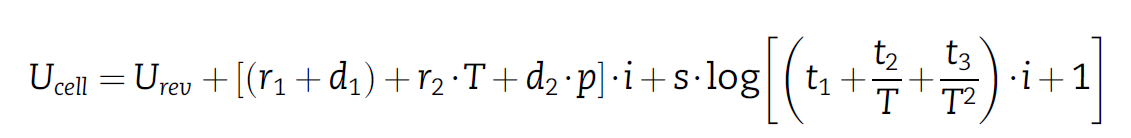

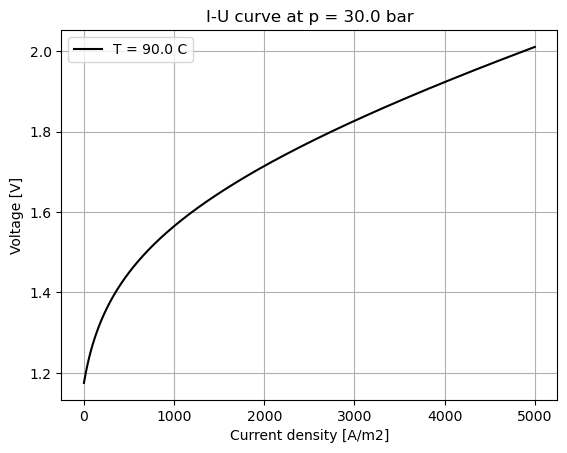

In [6]:
# Coefficients from Sanchez paper
r1 = 4.45153e-5 # Electrolyte ohmic resistive parameter r1 [Ohm m2]
r2 = 6.88874e-9 # Electrolyte ohmic resistive parameter r2 [Ohm m2 C-1]
d1 = -3.12996e-6 # [Ohm m2]
d2 = 4.47137e-7 # [Ohm m2 bar-1]
s = 0.33824 # Over voltage parameter of electrode [V] 
t1 = -0.01539 # Over voltage parameter of electrode [A-1 m2]  
t2 = 2.00181 # Over voltage parameter of electrode [A-1 m2 C]
t3 = 15.24178 # Over voltage parameter of electrode [A-1 m2 C^2] 

# Range of current density
i_0_5000=np.linspace(0, i_max, num=500)

# Voltage as a function of current density, temperature and pressure
def U_cell(i,T,p):
    U_cell = U_rev(T)+(r1+d1+r2*T+d2*p)*i+s*np.log10((t1+t2/T+t3/T**2)*i+1) # Temperature in Celsium
    return(U_cell)

# Plots at constant temperature
plt.title('I-U curve at p = %.1f bar' %Pr )
plt.xlabel('Current density [A/m2]')
plt.ylabel('Voltage [V]')
plt.plot(i_0_5000, U_cell(i_0_5000,T_op, Pr), label='T = %.1f C'  %T_op, color = black)
plt.legend()
plt.grid()

## 1.5 Power consumption of the electrolyzer
Power density:
p=U*i --> p(T,i,p)=U(T,i,p) * i [W/m2]


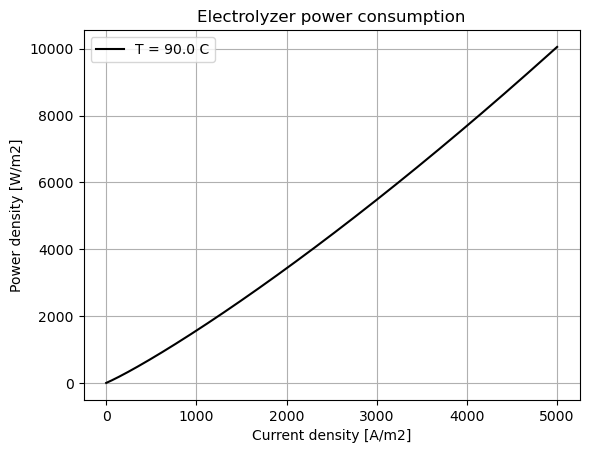

In [7]:
# Cell power density consumption as a function of temperature and current density [W/m2]
def P_cell(i, T, p):
    P_cell = U_cell(i, T, p) * i
    return(P_cell)

plt.title('Electrolyzer power consumption' )
plt.xlabel('Current density [A/m2]')
plt.ylabel('Power density [W/m2]')
plt.plot(i_0_5000, P_cell(i_0_5000, T_op, Pr), label='T = %.1f C'  %T_op, color = black)
plt.legend()
plt.grid()


In [8]:
# Calculate the total cell area (necessary to have the desired El_cap)
AA = El_cap*10**(6)/P_cell(i_max, T_op, Pr)  #m2
print('The total area of the cells is  %.1f m2' %AA )

The total area of the cells is  1989.6 m2


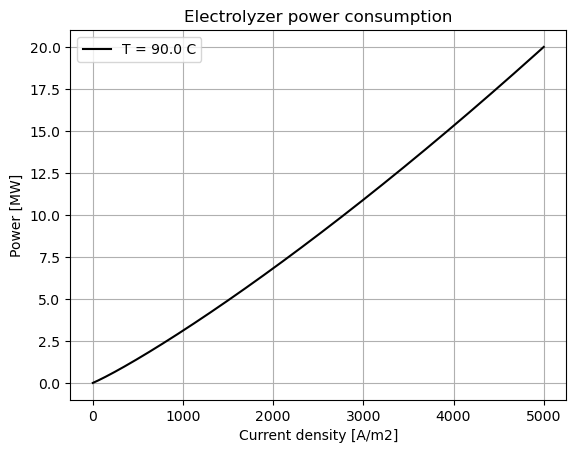

In [9]:
# Power consumption of the stack [MW]
def P_stack(i, T, p):
    P_stack = P_cell(i, T, p) * AA * 10**(-6)
    return(P_stack)

plt.title('Electrolyzer power consumption' )
plt.xlabel('Current density [A/m2]')
plt.ylabel('Power [MW]')
plt.plot(i_0_5000, P_stack(i_0_5000, T_op, Pr), label='T = %.1f C'  %T_op, color = black)
plt.legend()
plt.grid()

In [10]:
# Function to find the current corresponding to a certain power value [MW]
def find_i_from_p(p_val,AA,T):
    i_pval = np.zeros(np.size(p_val))
    for j in range(np.size(p_val)):
        cc=p_val[j]
        def P_stack_cc(i, T=T_op, p=Pr):
            P_stack_cc = P_cell(i, T, p) * AA * 10**(-6) - cc
            return(P_stack_cc)
        i_pval[j] = fsolve(P_stack_cc,[2000])
    return i_pval

# Find the current corresponding to the minimum allowed operating power (P_min)
p_val = np.array([P_min*El_cap])
i_min = find_i_from_p(p_val,AA,T_op)
print('The minimum operating current is %.1f A/m2' %i_min)

The minimum operating current is 967.3 A/m2


In [11]:
# Vectors relating current density and power
p_0_5000 = P_stack(i_0_5000, T_op, Pr)

i_min_max = np.linspace(i_min, i_max, num=500)
p_min_max = P_stack(i_min_max, T_op, Pr)

## 1.6 Faraday efficiency
The Faraday efficiency is the ration between the hydrogen produced and theoretical hydrogen that would be produced in accordance with Faraday's law. The Faraday efficiency is lower than 1 at lower loads. For an alkaline electrolyzer, the Faraday efficiency is in the range 85-95%.
Values different from the theoretical hydrogen production are obtained becasue of: energy consumption used for the electrolysis of impurities present in the electrolyte, the spontaneous recombination of reaction products that are not appropriately separated in tduring operation, etc.

(-250.0, 5250.0, 0.0, 1.0)

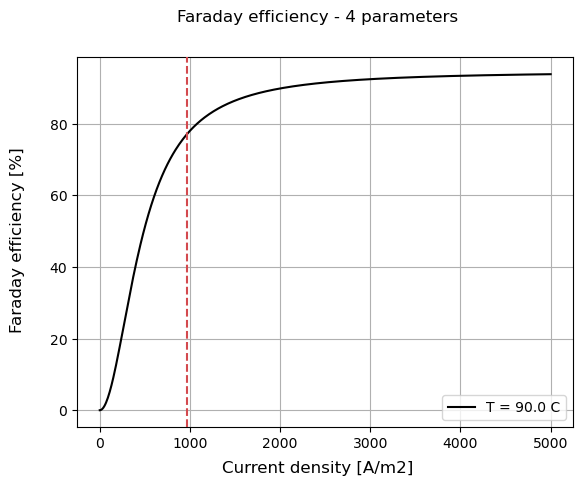

In [12]:
# Formulataion with 4 parameters (based on Ulleberg)

f11 = 478645.74 # A2 m-4
f12 = -2953.15 # A2 m-4 C-1
f21 = 1.03960
f22 = -0.00104 #C-1 

def eta_farad(i,T):
    eta_farad = (i**2./(f11+f12*T+i**2))*(f21+f22*T)
    return(eta_farad)

fig, ax1 = plt.subplots(1,1)
fig.suptitle('Faraday efficiency - 4 parameters')
fig.supylabel('Faraday efficiency [%]')
fig.supxlabel('Current density [A/m2]')
ax1.plot(i_0_5000, eta_farad(i_0_5000, T_op)*100, label='T = %.1f C'  %T_op, color = black)
ax1.legend(loc='lower right')
ax1.grid()

ax2 = ax1.twinx()
ax2.axvline(i_min,linestyle='dashed',color=red)
ax2.axis('off')

(-5.0, 105.0, 0.0, 1.0)

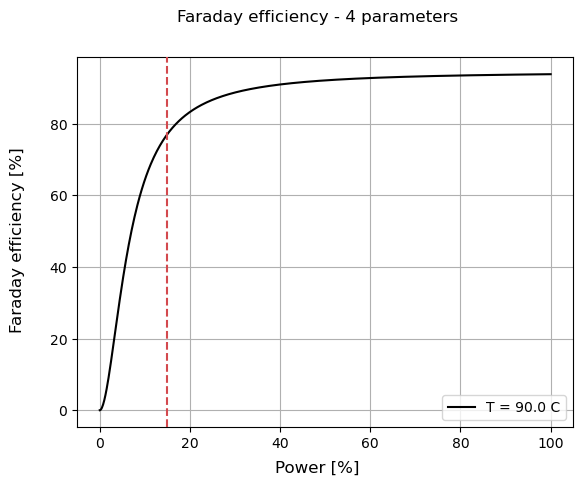

In [13]:
# Faraday efficiency as a function of power %

fig, ax1 = plt.subplots(1,1)
fig.suptitle('Faraday efficiency - 4 parameters')
fig.supylabel('Faraday efficiency [%]')
fig.supxlabel('Power [%]')
ax1.plot(p_0_5000/El_cap*100, eta_farad(i_0_5000, T_op)*100, label='T = %.1f C'  %T_op, color = black)
ax1.legend(loc='lower right')
ax1.grid()

ax2 = ax1.twinx()
ax2.axvline(P_min*100,linestyle='dashed',color=red)
ax2.axis('off')

## 1.7 Hydrogen production

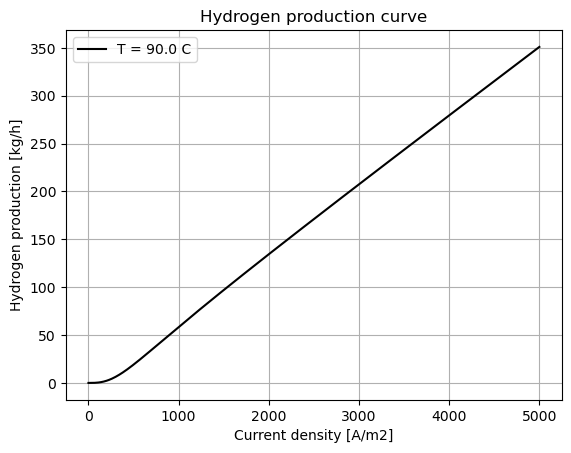

In [14]:
# Hydrogen production kg/h

def h_prod(i,T,p):
    h_prod = eta_farad(i,T)*M_h2*i/(2*F) * AA * 3600
    return h_prod

plt.title('Hydrogen production curve')
plt.xlabel('Current density [A/m2]')
plt.ylabel('Hydrogen production [kg/h]')
plt.plot(i_0_5000, h_prod(i_0_5000, T_op, Pr), label='T = %.1f C'  %T_op, color = black)
plt.legend()
plt.grid()


(3.0, 20.0)

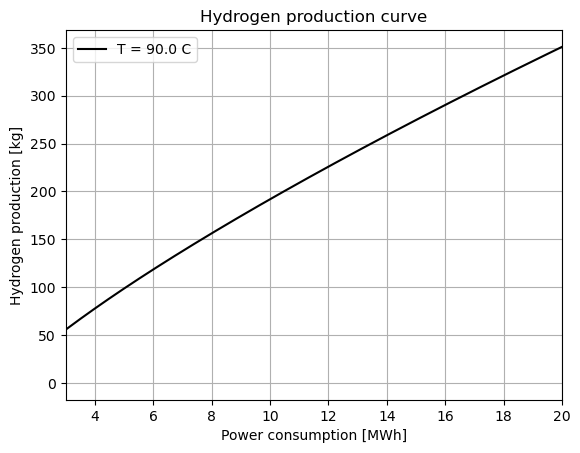

In [15]:
#%matplotlib qt
plt.title('Hydrogen production curve')
plt.xlabel('Power consumption [MWh]')
plt.ylabel('Hydrogen production [kg]')
plt.plot(p_0_5000, h_prod(i_0_5000, T_op, Pr), label='T = %.1f C'  %T_op, color = black)
plt.legend()
plt.grid()
plt.xlim([P_min*El_cap, El_cap])


## 1.8 Efficiency curve

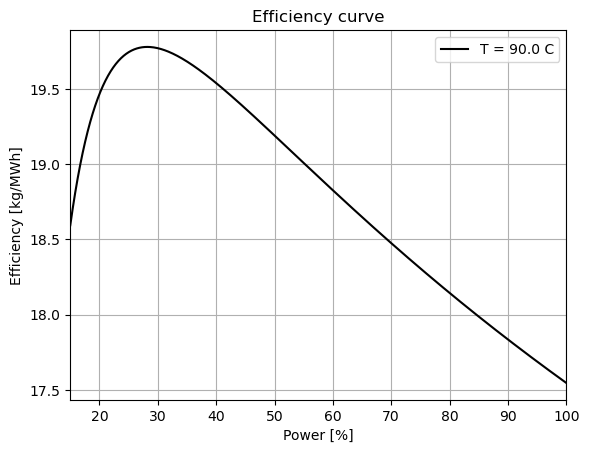

In [16]:
# Function for efficiency as a function of current desnity, temperature, pressure

def eta(i,T,p):
    eta = h_prod(i,T,p)/P_stack(i,T,p)
    return eta

plt.title('Efficiency curve' )
plt.xlabel('Power [%]')
plt.ylabel('Efficiency [kg/MWh]')
plt.plot(p_min_max/El_cap*100, eta(i_min_max, T_op, Pr), label='T = %.1f C'  %T_op, color = black)
plt.legend()
plt.grid()
plt.xlim([P_min*100, 100])
plt.show()


# 2. Piecewise linearization of the hydrogen production curve

In [24]:
# Find power with maximum efficiency
eta_max_pos=np.argmax(eta(i_min_max, T_op, Pr))
i_eta_max=i_min_max[eta_max_pos]
P_eta_max=P_stack(i_eta_max,T_op, Pr)/El_cap # 0.28 at 90 degrees! But it changes with T!
eta_max=eta(i_eta_max,T_op, Pr) # 19.62 at 90 degrees

print('The power with maximum efficiency is at %.2f percent of the nominal power.' %(P_eta_max*100))

The power with maximum efficiency is at 28.23 percent of the nominal power.


In [25]:
# Define the linearization power points
#p_val = np.array([P_min, 0.2, P_eta_max[0], 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1 ])*El_cap
p_val = np.array([P_min, 1 ])*El_cap
#p_val = np.array([P_min, P_eta_max[0], 0.65, 1])*El_cap

# Calculate the corresponding current densities
i_val = find_i_from_p(p_val,AA,T_op)

N_pw=len(p_val) # Number of piecewise discretization points
N_s = N_pw - 1 # Number of discretization segments
S = np.array([t for t in range(0, N_s)]) # Set with discretization segments

In [26]:
# Function to find the linear coefficients 
def lin_coeff(x,y):
    coeff = np.polyfit(x,y, 1)
    # y=coeff[1]+coeff[0]*x
    return coeff[1], coeff[0]

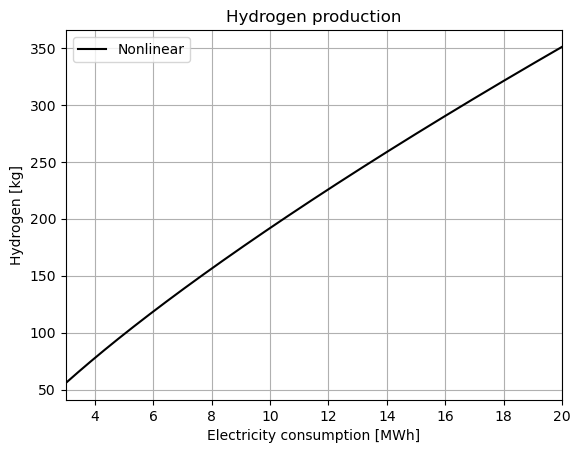

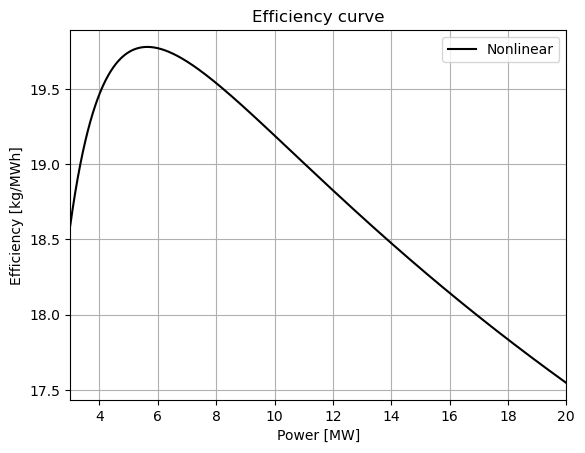

In [27]:
# Plot the original nolinear curves

# Production curve
plt.figure()
fig_prod=plt.gcf().number
plt.title('Hydrogen production')
plt.xlabel('Electricity consumption [MWh]')
plt.ylabel('Hydrogen [kg]')
plt.plot(p_min_max, h_prod(i_min_max, T_op, Pr), label='Nonlinear', color = black)
plt.legend()
plt.grid()
plt.xlim([P_min*El_cap, El_cap])

# Efficiency
plt.figure()
fig_eff=plt.gcf().number
plt.title('Efficiency curve' )
plt.xlabel('Power [MW]')
plt.ylabel('Efficiency [kg/MWh]')
plt.plot(p_min_max, eta(i_min_max, T_op, Pr),label='Nonlinear', color = black)
plt.legend()
plt.grid()
plt.xlim([P_min*El_cap, El_cap])
plt.show()

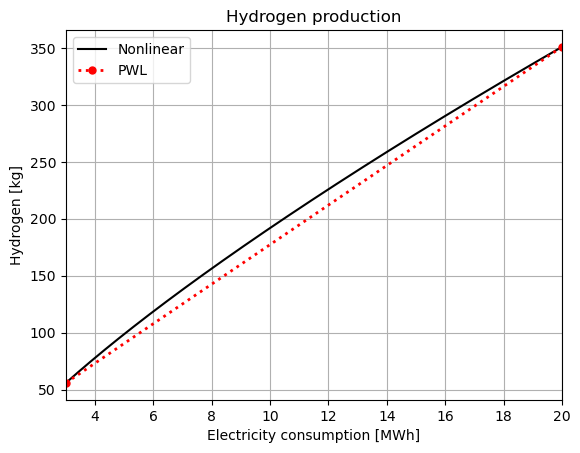

In [28]:
# Calculate the a and b coefficients for each segment and plot them on the original curve

# Plot the original nolinear hydrogen production curve
fig_prod = plt.figure()
plt.title('Hydrogen production')
plt.xlabel('Electricity consumption [MWh]')
plt.ylabel('Hydrogen [kg]')
plt.plot(p_min_max, h_prod(i_min_max, T_op, Pr), label='Nonlinear', color = black)
plt.grid()
plt.xlim([P_min*El_cap, El_cap])

# Calculate coefficients
a=np.zeros(N_s)
b=np.zeros(N_s)

for jj in range(0, N_s):
    x=np.concatenate((np.array([p_val[jj]]),np.array([p_val[jj+1]])))
    y=np.concatenate((np.array([h_prod(i_val[jj],T_op,Pr)]),np.array([h_prod(i_val[jj+1],T_op,Pr)])))
    b[jj], a[jj] = lin_coeff(x,y)
    # Plot hydrogen production in each segment
    plt.plot(x, (b[jj]+a[jj]*x), ":.", color='red', linewidth=2, label='Piecewise linearization', markersize=10)  
plt.legend(['Nonlinear', 'PWL'])

fig_prod.savefig('Figures/production.png')
    

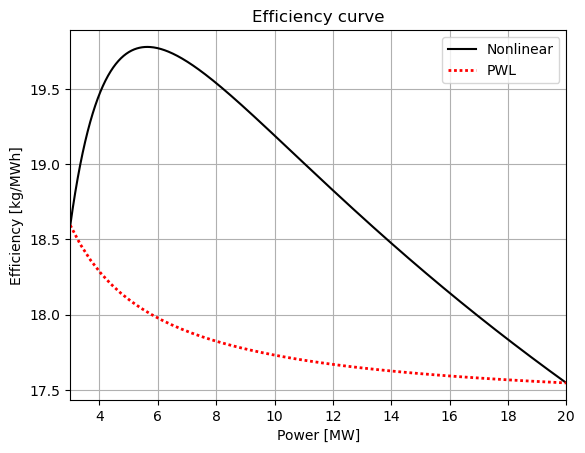

In [29]:
# Plot the original nonlinear efficiency curve
fig_eff = plt.figure()
plt.title('Efficiency curve' )
plt.xlabel('Power [MW]')
plt.ylabel('Efficiency [kg/MWh]')
plt.plot(p_min_max, eta(i_min_max, T_op, Pr),label='Nonlinear', color = black)
plt.grid()
plt.xlim([P_min*El_cap, El_cap])

# Plot the approximated efficiency curve
for jj in range(0, N_s):
    p_vec=np.linspace(p_val[jj],p_val[jj+1])
    plt.plot(p_vec, (a[jj]+b[jj]/(p_vec)), color='red', linewidth=2, label='Piecewise linearization', linestyle='--', dashes=(1, 1)) 
plt.legend(['Nonlinear', 'PWL'])
plt.show()
fig_eff.savefig('Figures/efficiency.png')

In [23]:
# Print table with a and b coefficiencts for each segment

# creating a list of column names
column_values = ['Segment number', 'P_j_%', 'P_j+1_%', 'P_j_MW', 'P_j+1_MW',  'a', 'b']
N_col = len(column_values)

array = np.zeros((N_s,N_col))
for jj in range(0,N_s):
    array[jj,:] = np.array([jj, p_val[jj]/El_cap, p_val[jj+1]/El_cap, p_val[jj], p_val[jj+1], a[jj], b[jj]])

df = pd.DataFrame(data = array, columns = column_values)
print(df)

   Segment number     P_j_%   P_j+1_%   P_j_MW  P_j+1_MW          a          b
0             0.0  0.150000  0.282315   3.0000    5.6463  21.122656  -7.584816
1             1.0  0.282315  0.650000   5.6463   13.0000  17.781238  11.281834
2             2.0  0.650000  1.000000  13.0000   20.0000  15.500205  40.935260
